## Libraries

In [113]:
#Lib import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns
from scipy.optimize import differential_evolution
import statsmodels.api as sm

In [112]:
# Additional instalations
#!pip install seaborn
#!pip install yfinance
#!pip install statsmodels

     ---------------------------------------- 9.8/9.8 MB 5.7 MB/s eta 0:00:00
     -------------------------------------- 232.9/232.9 kB 7.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Instructions

Compute daily returns if not already done so

Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time? 

## Data preprocessing

In [3]:
def load_data(stock_files, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Date range
    start_date = '2021-01-01'  # January 1, 2021
    end_date = '2024-10-26'    # October 26, 2024
    
    # Data download
    for ticker, file in stock_files.items():
        try:
            # Get stock data
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)
            
            # Convert index to date format without time component
            df.index = df.index.date
            
            # Name the index column
            df.index.name = 'Date'
            
            # Save to CSV
            output_path = os.path.join(output_dir, file)
            df.to_csv(output_path)

In [4]:
# Define the directory containing your stock data
data_dir = r"D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data"
risk_free_file = r'D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'

stock_files = {
    'SPLP': 'Steel Partners Holdings L.P. Stock Price History.csv',
    'TEAM': 'Atlassian Stock Price History.csv',
    'BIDU': 'Baidu Stock Price History.csv',
    'ADBE': 'Adobe Stock Price History.csv',
    'MDLZ': 'Mondelez Stock Price History.csv',
    'AMD': 'AMD Stock Price History.csv',
    'VRSN': 'Verisign Stock Price History.csv',
    'PAYX': 'Paychex Stock Price History.csv',
}

In [5]:
# Download
stock_data = load_data(stock_files,'stock_data')

Successfully downloaded data for SPLP to Steel Partners Holdings L.P. Stock Price History.csv
Successfully downloaded data for TEAM to Atlassian Stock Price History.csv
Successfully downloaded data for BIDU to Baidu Stock Price History.csv
Successfully downloaded data for ADBE to Adobe Stock Price History.csv
Successfully downloaded data for MDLZ to Mondelez Stock Price History.csv
Successfully downloaded data for AMD to AMD Stock Price History.csv
Successfully downloaded data for VRSN to Verisign Stock Price History.csv
Successfully downloaded data for PAYX to Paychex Stock Price History.csv


In [57]:
# Open and Close prices -> daily returns
def calculate_daily_returns(data):
    data['Daily_Return'] = np.log(data['Close'] / data['Open'])
    return data[['Date', 'Daily_Return']]

Loading data into one table and filter 1 Yr risk free rate with the Date


In [58]:
# Load stock data and get daily returns
daily_returns = {} 
all_data = {}  # Dictionary with ticker as key

for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data

stock_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)

In [69]:
# Load risk free rate
risk_free_rate = pd.read_csv(risk_free_file)
risk_free_rate.columns = risk_free_rate.columns.str.strip()

risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')
risk_free_rate['Date'] = pd.to_datetime(risk_free_rate['Date'], dayfirst=True, errors='coerce')
risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

# Get correct time range
mask = (risk_free_rate['Date'] >= '2021-01-01') & (risk_free_rate['Date'] <= '2024-10-25')
risk_free_rate = risk_free_rate.loc[mask]

# Get daily values
risk_free_rate['Daily_Rate'] = np.log(1 + risk_free_rate['1 Mo'] / 100)  / 252

# Align with stock data
risk_free_rate.set_index('Date', inplace=True)

In [70]:
def clean_dates_with_ffill(stock_returns, risk_free_rate):
    # Convert dates to correct format
    risk_free_dates = pd.to_datetime(risk_free_rate.index).date
    stock_dates = stock_returns.index.tz_localize(None)  # Remove timezone
    stock_dates = pd.to_datetime(stock_dates).date
    
    # Find missing dates
    risk_free_dates_set = set(risk_free_dates)
    stock_dates_set = set(stock_dates)
    missing_free = sorted(stock_dates_set - risk_free_dates_set) 
    missing_stock = sorted(risk_free_dates_set - stock_dates_set)
    
    # Create cleaned stock returns
    cleaned_stock_returns = stock_returns.copy()
    cleaned_stock_returns.index = stock_dates
    
    # Forward fill missing risk-free rates
    cleaned_risk_free_rate = risk_free_rate.copy()
    cleaned_risk_free_rate.index = risk_free_dates
    cleaned_risk_free_rate = cleaned_risk_free_rate.reindex(cleaned_stock_returns.index).ffill()
    
    # Return missing dates and cleaned data
    return missing_free, missing_stock, cleaned_stock_returns, cleaned_risk_free_rate

In [71]:
# Clean the data
filled_dates, missing_dates, clean_returns, clean_risk_free = clean_dates_with_ffill(stock_returns, risk_free_rate)

print(len(missing_dates), "days omitted for missing stock returns and", len(filled_dates), "missing risk free rates forward filled.")

missing_dates = pd.to_datetime(missing_dates)

stock_returns = stock_returns[~stock_returns.index.isin(missing_dates)]
risk_free_rate = clean_risk_free

2 days omitted for missing stock returns and 6 missing risk free rates forward filled.


## Exploratory Analysis

In [72]:
# Summary of Risk-Free Rate and stock returns
print("\nDaily Returns Summary:")
print(stock_returns.describe())

print("\nRisk-Free Rate Summary:")
print(risk_free_rate.describe())


Daily Returns Summary:
             SPLP        TEAM        BIDU        ADBE        MDLZ         AMD  \
count  960.000000  960.000000  960.000000  960.000000  960.000000  960.000000   
mean     0.002203    0.000957   -0.000254   -0.000086   -0.000209   -0.000300   
std      0.020071    0.029575    0.024521    0.017442    0.010214    0.027194   
min     -0.091406   -0.106688   -0.133468   -0.076126   -0.070633   -0.108413   
25%     -0.005124   -0.015459   -0.013971   -0.009974   -0.005947   -0.015055   
50%      0.000000    0.002490   -0.000975    0.000600   -0.000132   -0.000225   
75%      0.008005    0.018334    0.011892    0.010951    0.005806    0.015178   
max      0.127833    0.109976    0.179819    0.102605    0.037771    0.109074   

             VRSN        PAYX  
count  960.000000  960.000000  
mean    -0.000052    0.000212  
std      0.012795    0.012545  
min     -0.050470   -0.062812  
25%     -0.007396   -0.007058  
50%      0.000118    0.000297  
75%      0.007493    0

In [74]:
# First 5 days
print("\n First 5 rows")
print(stock_returns.head())
print("\n Last 5 rows")
print(risk_free_rate.tail())


 First 5 rows
                SPLP      TEAM      BIDU      ADBE      MDLZ       AMD  \
Date                                                                     
2021-01-04 -0.049940 -0.012617 -0.012422 -0.030358 -0.009793  0.002061   
2021-01-05  0.005731  0.010377  0.002667 -0.000391  0.001553  0.007248   
2021-01-06  0.023289 -0.019586 -0.042286 -0.016568 -0.002072 -0.014180   
2021-01-07 -0.028560  0.023191  0.000866  0.014209  0.000693  0.041080   
2021-01-08  0.028560 -0.002206  0.056466  0.010569  0.014192 -0.014694   

                VRSN      PAYX  
Date                            
2021-01-04 -0.015517 -0.031053  
2021-01-05 -0.025389 -0.004655  
2021-01-06 -0.020735  0.012808  
2021-01-07 -0.001998  0.005917  
2021-01-08  0.007487  0.005995  

 Last 5 rows
            1 Mo  Daily_Rate
2024-10-21  4.92    0.000191
2024-10-22  4.89    0.000189
2024-10-23  4.88    0.000189
2024-10-24  4.87    0.000189
2024-10-25  4.89    0.000189


In [75]:
# Exploratory analysis
mean_returns = stock_returns.mean()
cov_matrix = stock_returns.cov()
auto_cov = stock_returns.apply(lambda col: col.autocorr())

print("\nExpected Returns (Mean):")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nAuto-covariances (Autocorrelations):")
print(auto_cov)

Performing exploratory analysis...

Expected Returns (Mean):
SPLP    0.002203
TEAM    0.000957
BIDU   -0.000254
ADBE   -0.000086
MDLZ   -0.000209
AMD    -0.000300
VRSN   -0.000052
PAYX    0.000212
dtype: float64

Covariance Matrix:
          SPLP      TEAM      BIDU      ADBE      MDLZ       AMD      VRSN  \
SPLP  0.000403  0.000049  0.000039  0.000040  0.000002  0.000060  0.000023   
TEAM  0.000049  0.000875  0.000268  0.000293  0.000033  0.000388  0.000168   
BIDU  0.000039  0.000268  0.000601  0.000152  0.000031  0.000248  0.000076   
ADBE  0.000040  0.000293  0.000152  0.000304  0.000036  0.000260  0.000123   
MDLZ  0.000002  0.000033  0.000031  0.000036  0.000104  0.000024  0.000046   
AMD   0.000060  0.000388  0.000248  0.000260  0.000024  0.000740  0.000127   
VRSN  0.000023  0.000168  0.000076  0.000123  0.000046  0.000127  0.000164   
PAYX  0.000033  0.000126  0.000073  0.000092  0.000050  0.000101  0.000081   

          PAYX  
SPLP  0.000033  
TEAM  0.000126  
BIDU  0.000073

#TBD
The expected returns show the average daily log returns for the assets. GOOGL and AVGO exhibit positive expected returns, indicating slight daily growth, while other assets, such as LULU and AMGN, have negative expected returns, suggesting slight daily losses. The covariance matrix highlights relationships in return variability between assets. For example, GOOGL and AVGO have a relatively high covariance (0.000141), suggesting they tend to move together. On the other hand, the autocovariances (or autocorrelations) suggest the persistence of daily returns over time; for instance, GOOGL and AMGN show slight positive autocorrelations, while TXN and DLTR exhibit notable negative autocorrelations.

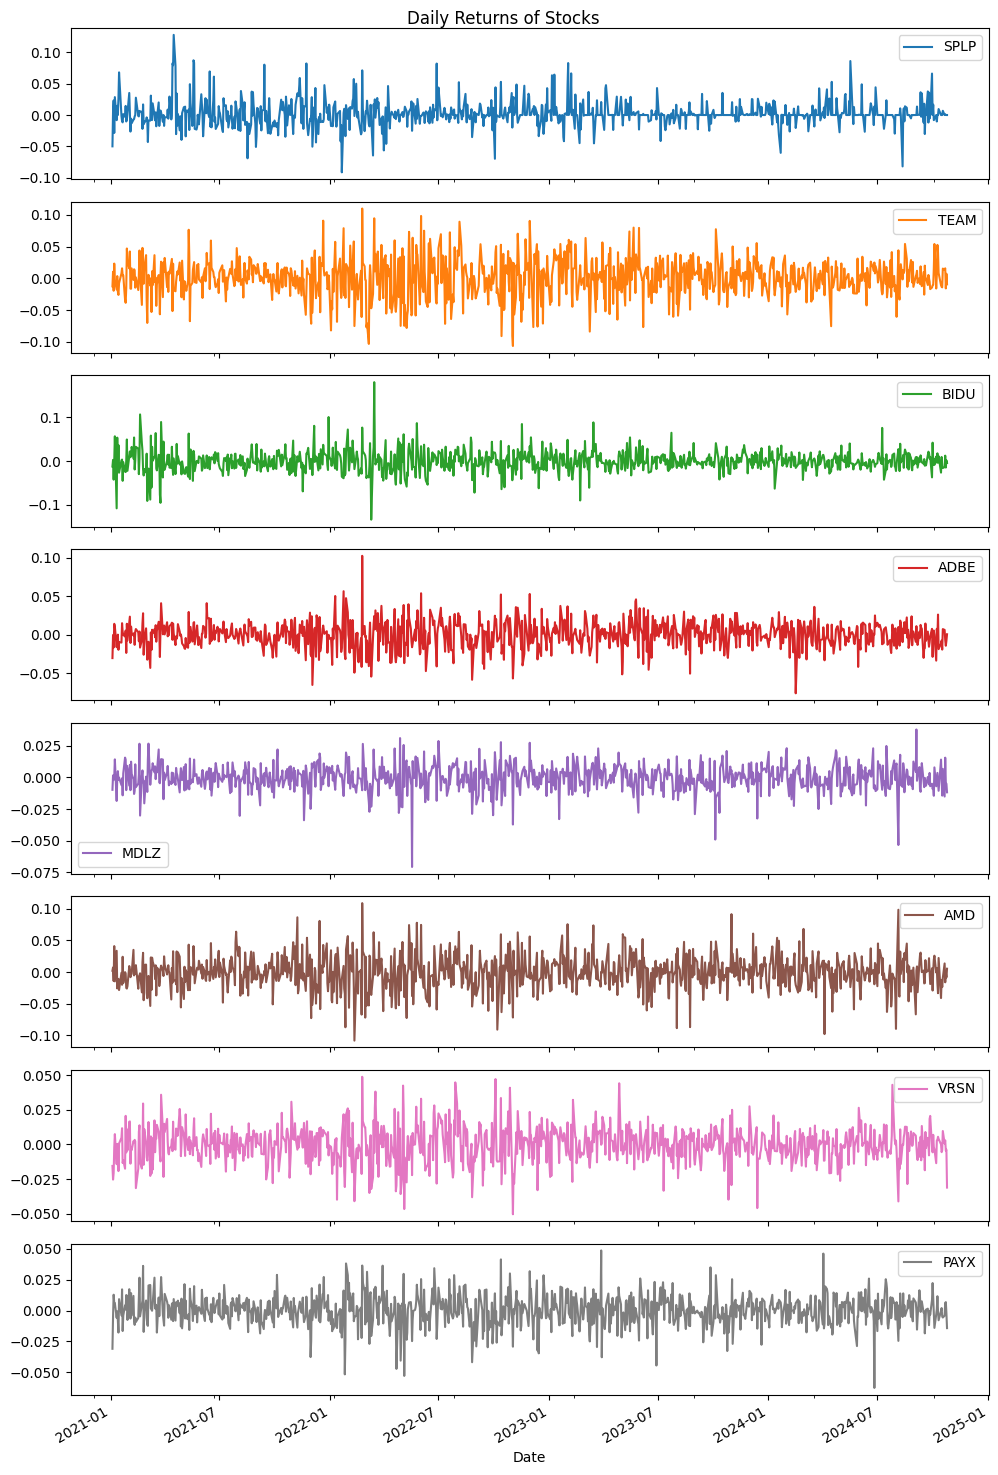

In [16]:
# Plotting daily returns
stock_returns.plot(subplots=True, figsize=(10, 15), title='Daily Returns of Stocks')
plt.tight_layout()
plt.show()

Some of them are showing homoscedascity and low autocovariance, and centered around 0.
#TODO: Mrknout na časové řady cvika a vyjmenovat různé ty vlastnosti a possibly dodělat nějaké grafy

In [76]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Basic info
        print("\nDataset Info:")
        print(df.info())
        
        # Summary statistics
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\nMissing Values:")
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close']) - np.log(df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: {df['Daily_Return'].mean():.4%}")
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: {df['Daily_Return'].max():.4%}")
        print(f"Maximum Daily Loss: {df['Daily_Return'].min():.4%}")
        
        # Plot price history
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'])
        plt.title(f'{ticker} Stock Price History')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        # Plot daily returns distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True)
        plt.title(f'{ticker} Daily Returns Distribution')
        plt.xlabel('Daily Return')
        plt.ylabel('Frequency')
        plt.show()

In [77]:
all_data['SPLP'] #all data in one frame (disctionary)
#combined_returns #This one is more important

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Daily_Return
0,2021-01-04,10.880000,10.970000,10.250000,10.350000,106400,0.0,0.0,SPLP,-0.049940
1,2021-01-05,10.440000,10.540000,10.300000,10.500000,54000,0.0,0.0,SPLP,0.005731
2,2021-01-06,10.610000,11.540000,10.610000,10.860000,101100,0.0,0.0,SPLP,0.023289
3,2021-01-07,11.010000,11.010000,10.700000,10.700000,45100,0.0,0.0,SPLP,-0.028560
4,2021-01-08,10.700000,11.030000,10.550000,11.010000,51700,0.0,0.0,SPLP,0.028560
...,...,...,...,...,...,...,...,...,...,...
955,2024-10-21,41.250000,41.250000,41.250000,41.250000,300,0.0,0.0,SPLP,0.000000
956,2024-10-22,40.950001,41.000000,40.599998,41.000000,2000,0.0,0.0,SPLP,0.001220
957,2024-10-23,41.000000,41.000000,41.000000,41.000000,0,0.0,0.0,SPLP,0.000000
958,2024-10-24,40.490002,40.490002,40.490002,40.490002,200,0.0,0.0,SPLP,0.000000



=== Data Exploration ===

Analysis for SPLP:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \

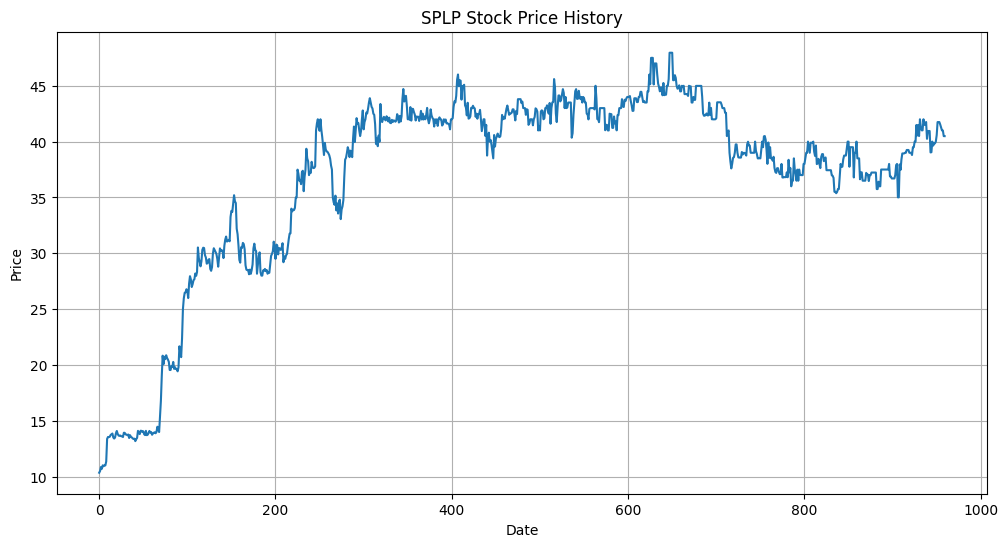

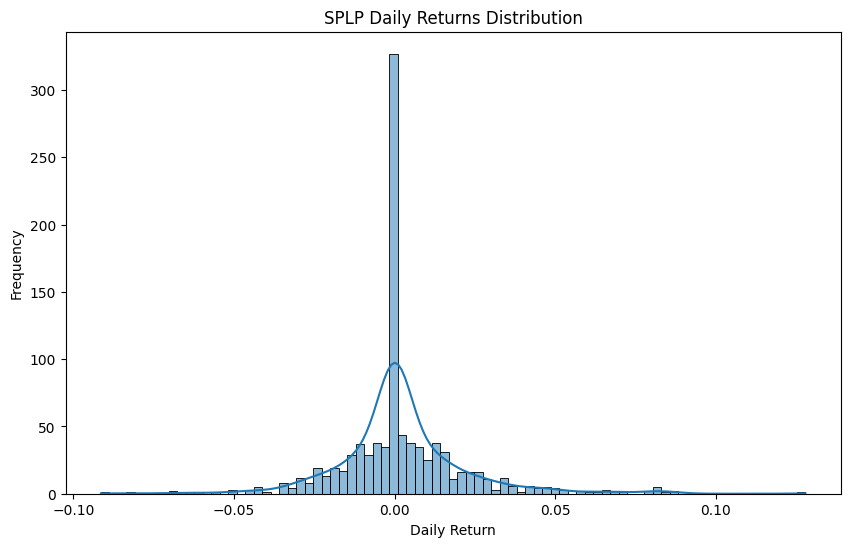


Analysis for TEAM:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

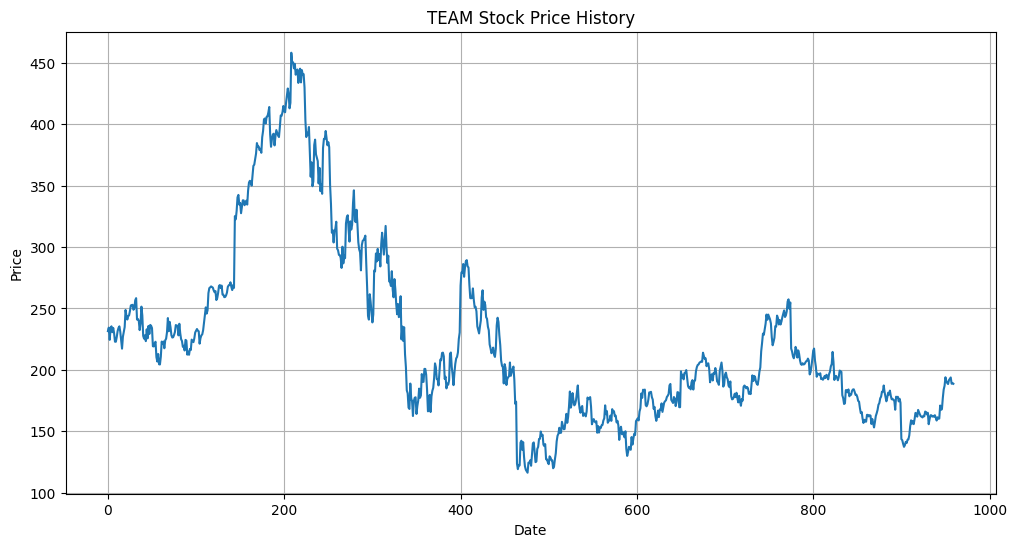

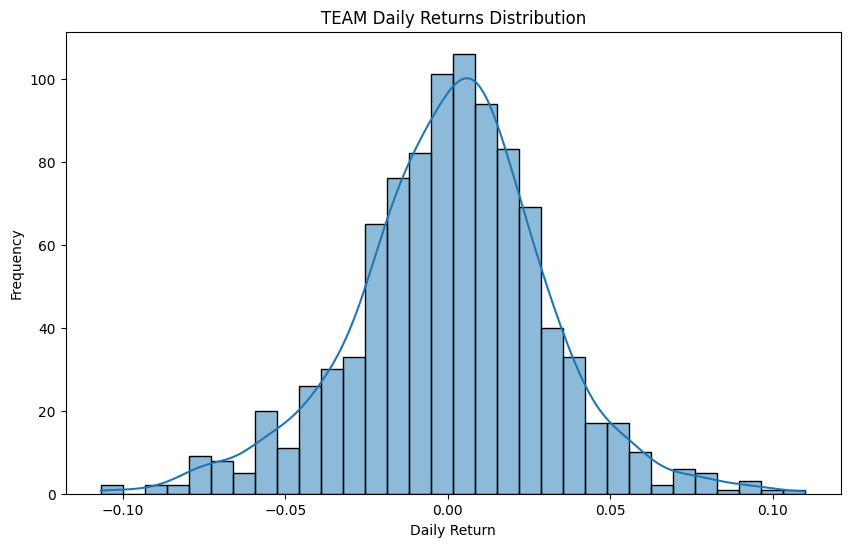


Analysis for BIDU:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

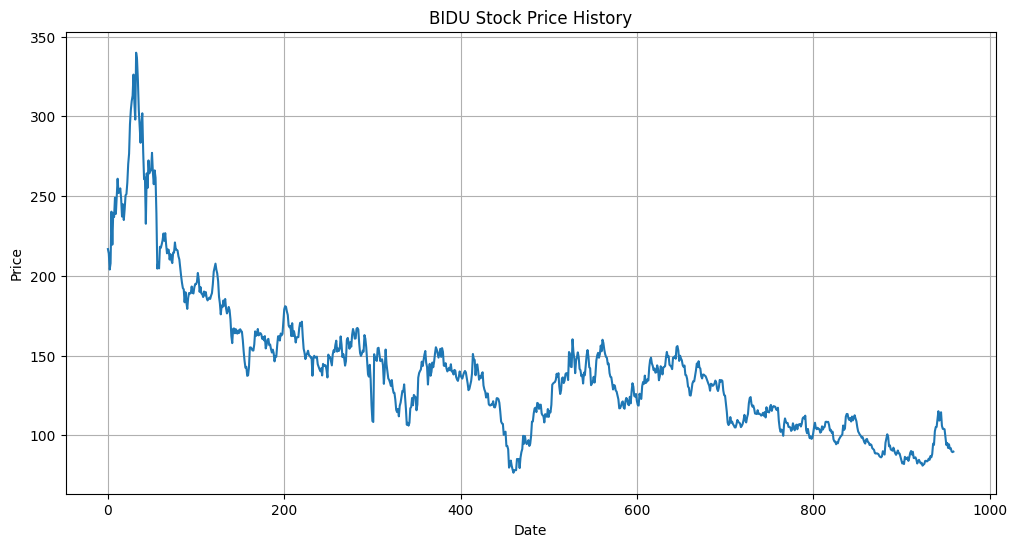

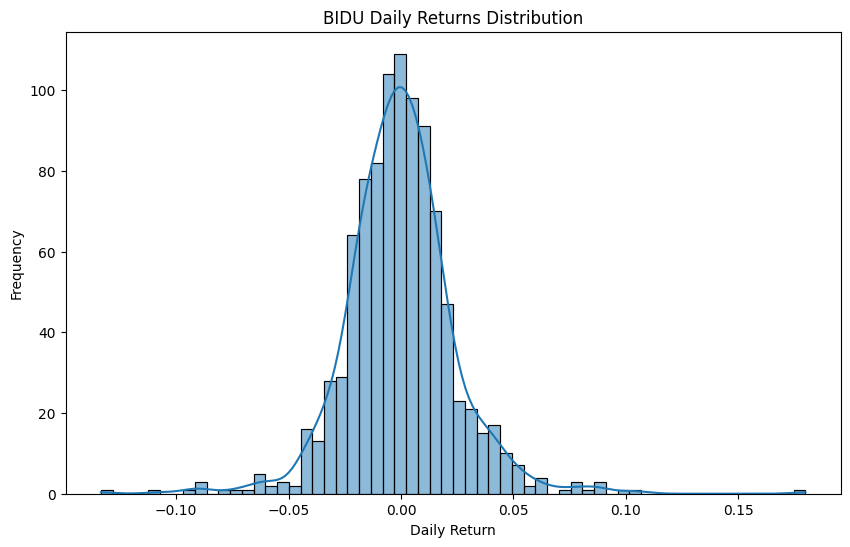


Analysis for ADBE:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

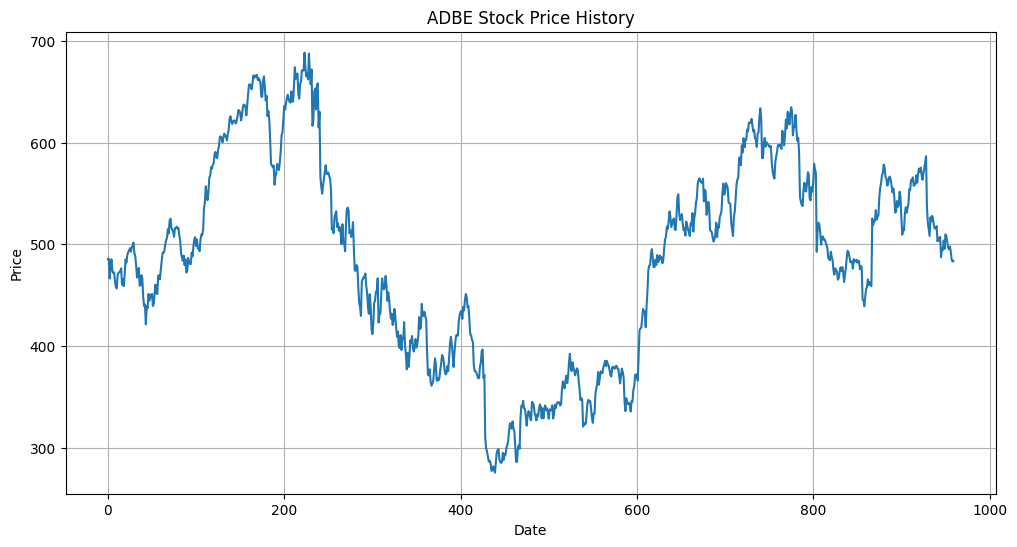

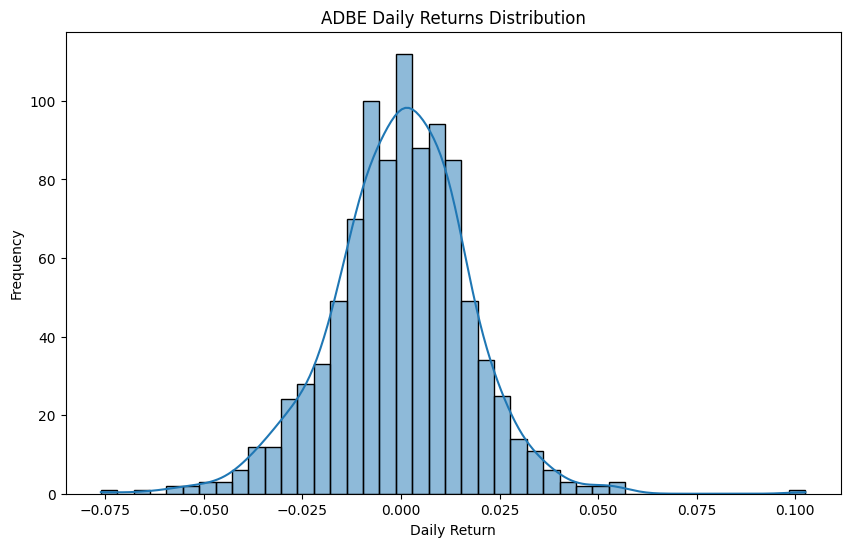


Analysis for MDLZ:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

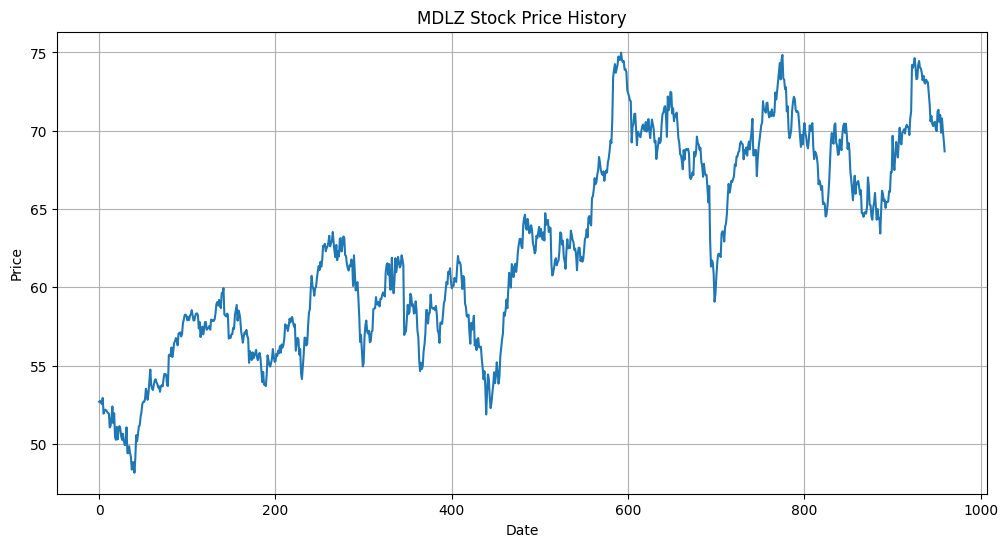

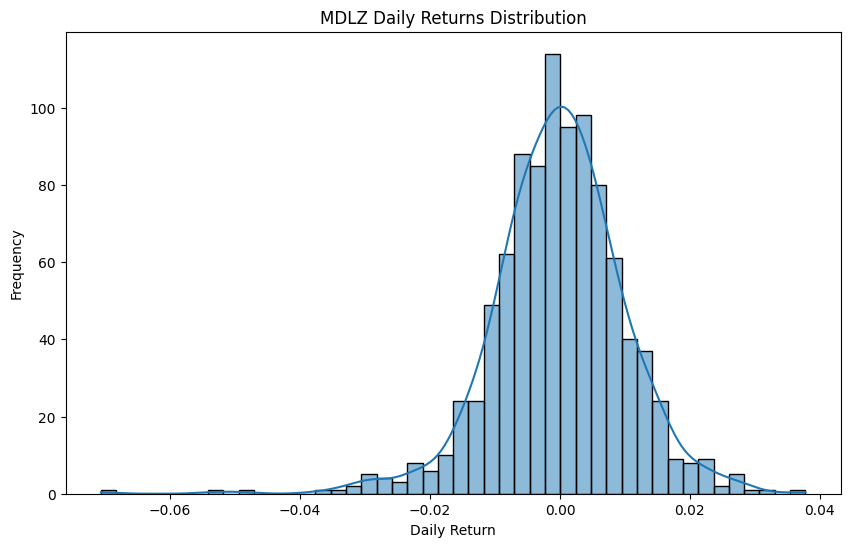


Analysis for AMD:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                     

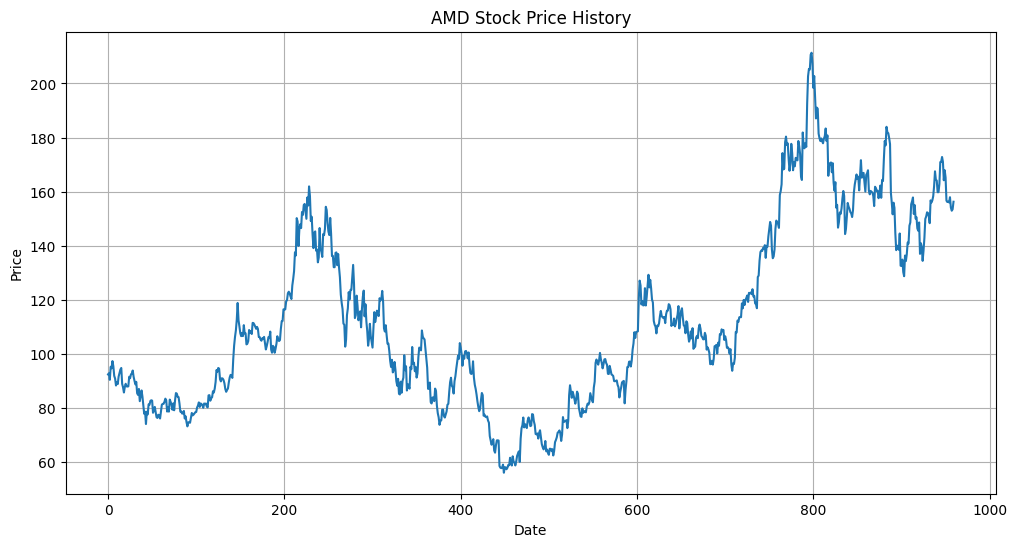

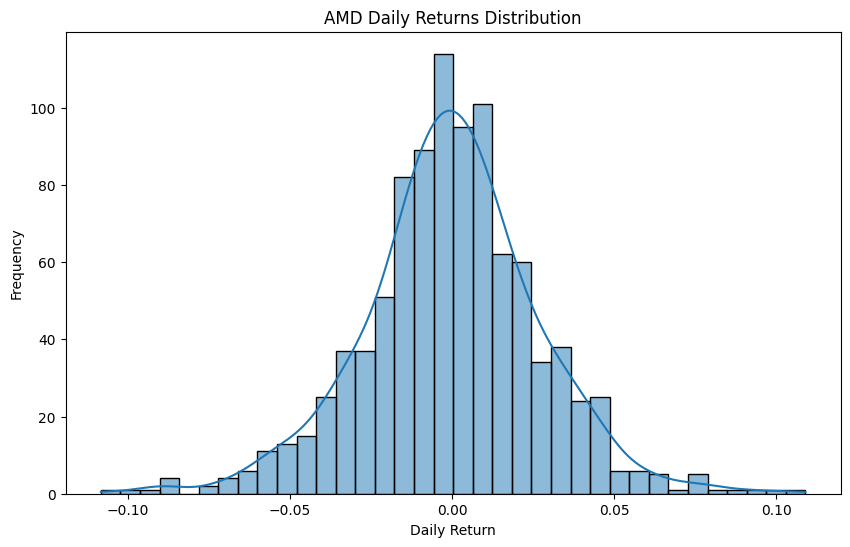


Analysis for VRSN:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

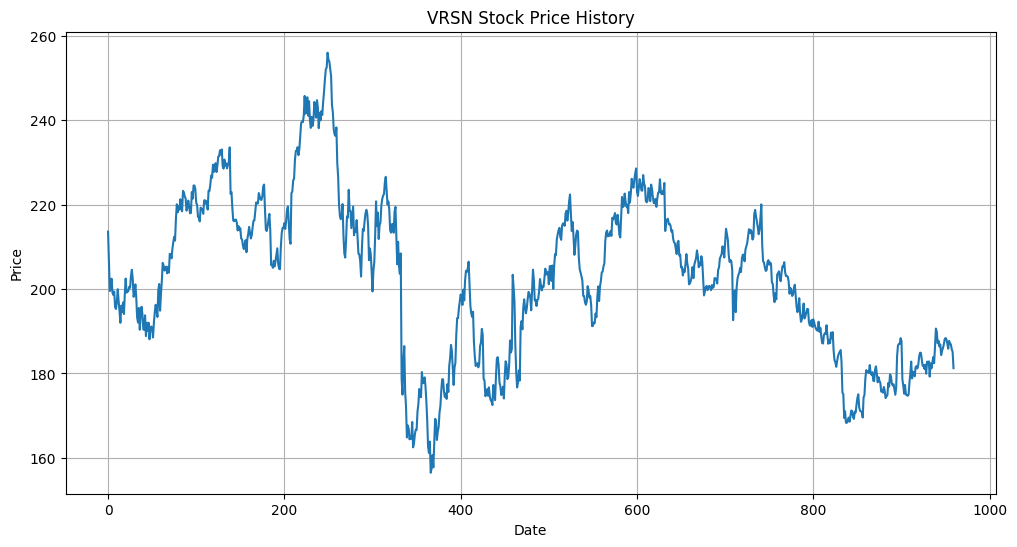

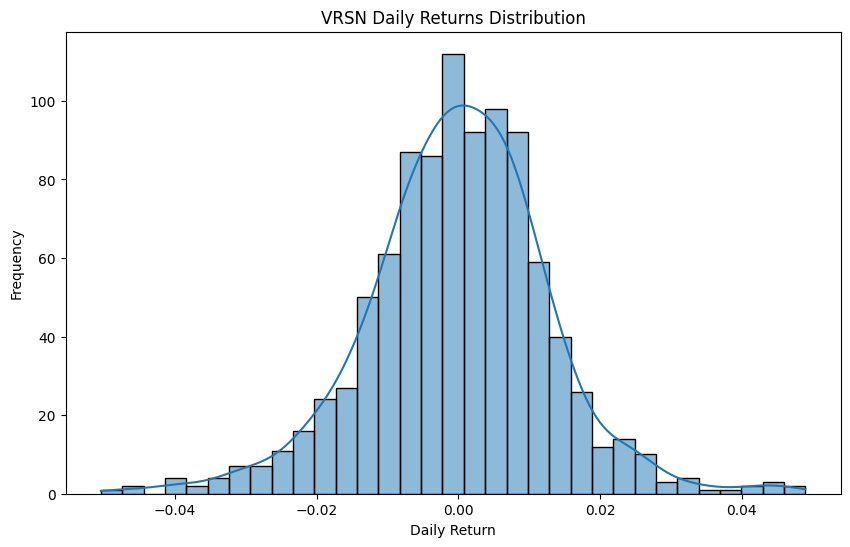


Analysis for PAYX:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

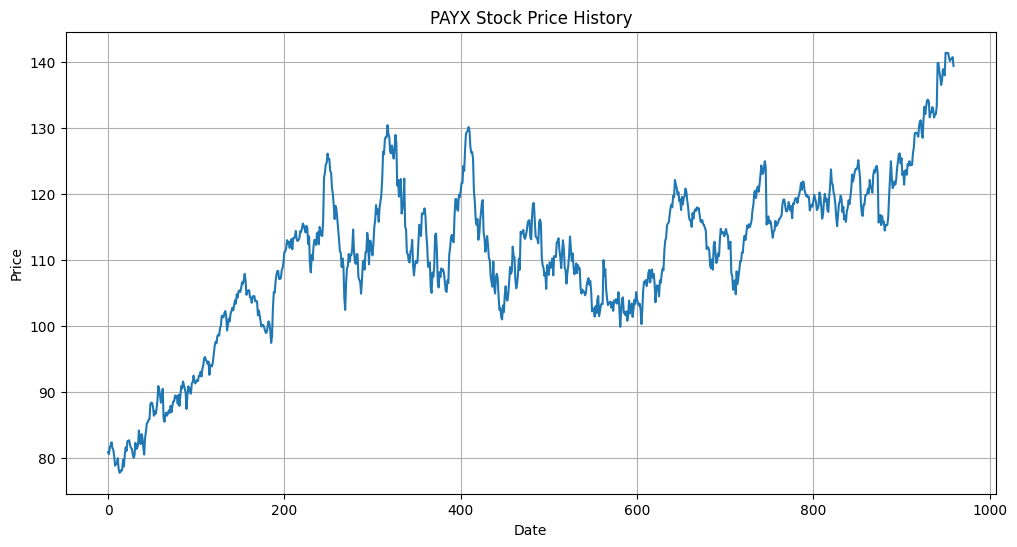

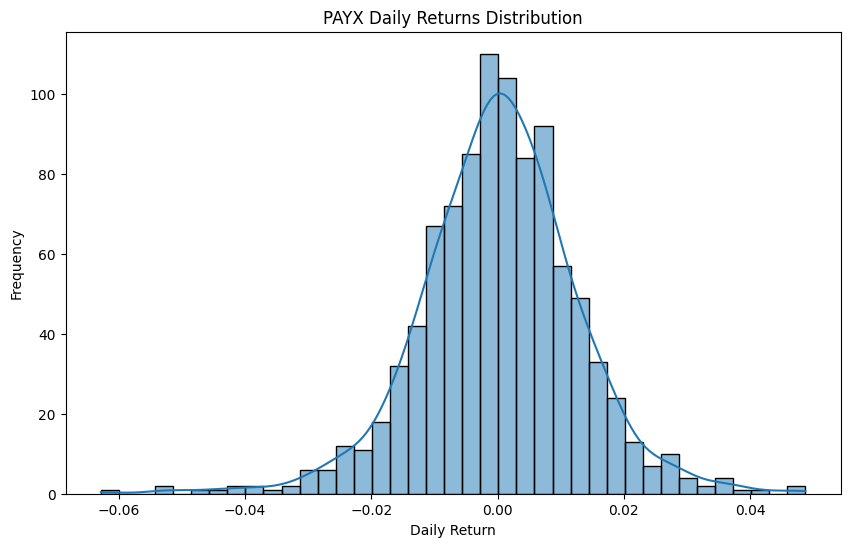

In [78]:
explore_data(all_data)

In [21]:
def plot_stock_data_comparisons(stock_data):
    """
    Plot multiple aspects of stock data for all tickers in the dictionary.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot Open Prices
    for ticker, df in stock_data.items():
        axes[0].plot(df.index, df['Open'], label=ticker)
    axes[0].set_title('Open Prices for All Stocks', fontsize=14)
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True)
    
    # Plot Volumes
    for ticker, df in stock_data.items():
        axes[1].plot(df.index, df['Volume'], label=ticker)
    axes[1].set_title('Volumes for All Stocks', fontsize=14)
    axes[1].set_ylabel('Volume')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    # Plot Low-High Range (Confidence Interval)
    for ticker, df in stock_data.items():
        axes[2].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label=ticker)
    axes[2].set_title('Low-High Range for All Stocks', fontsize=14)
    axes[2].set_ylabel('Price Range')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True)

    # Plot Dividends
    for ticker, df in stock_data.items():
        axes[3].plot(df.index, df['Dividends'], label=ticker)
    axes[3].set_title('Dividends for All Stocks', fontsize=14)
    axes[3].set_ylabel('Dividends')
    axes[3].legend(loc='best', fontsize=10)
    axes[3].grid(True)

    # Plot Daily Returns
    for ticker, df in stock_data.items():
        axes[4].plot(df.index, df['Daily_Return'], label=ticker)
    axes[4].set_title('Daily Returns for All Stocks', fontsize=14)
    axes[4].set_ylabel('Daily Return')
    axes[4].legend(loc='best', fontsize=10)
    axes[4].grid(True)

    # Adjust layout and show plot
    plt.xlabel('Date', fontsize=12)
    plt.tight_layout()
    plt.show()


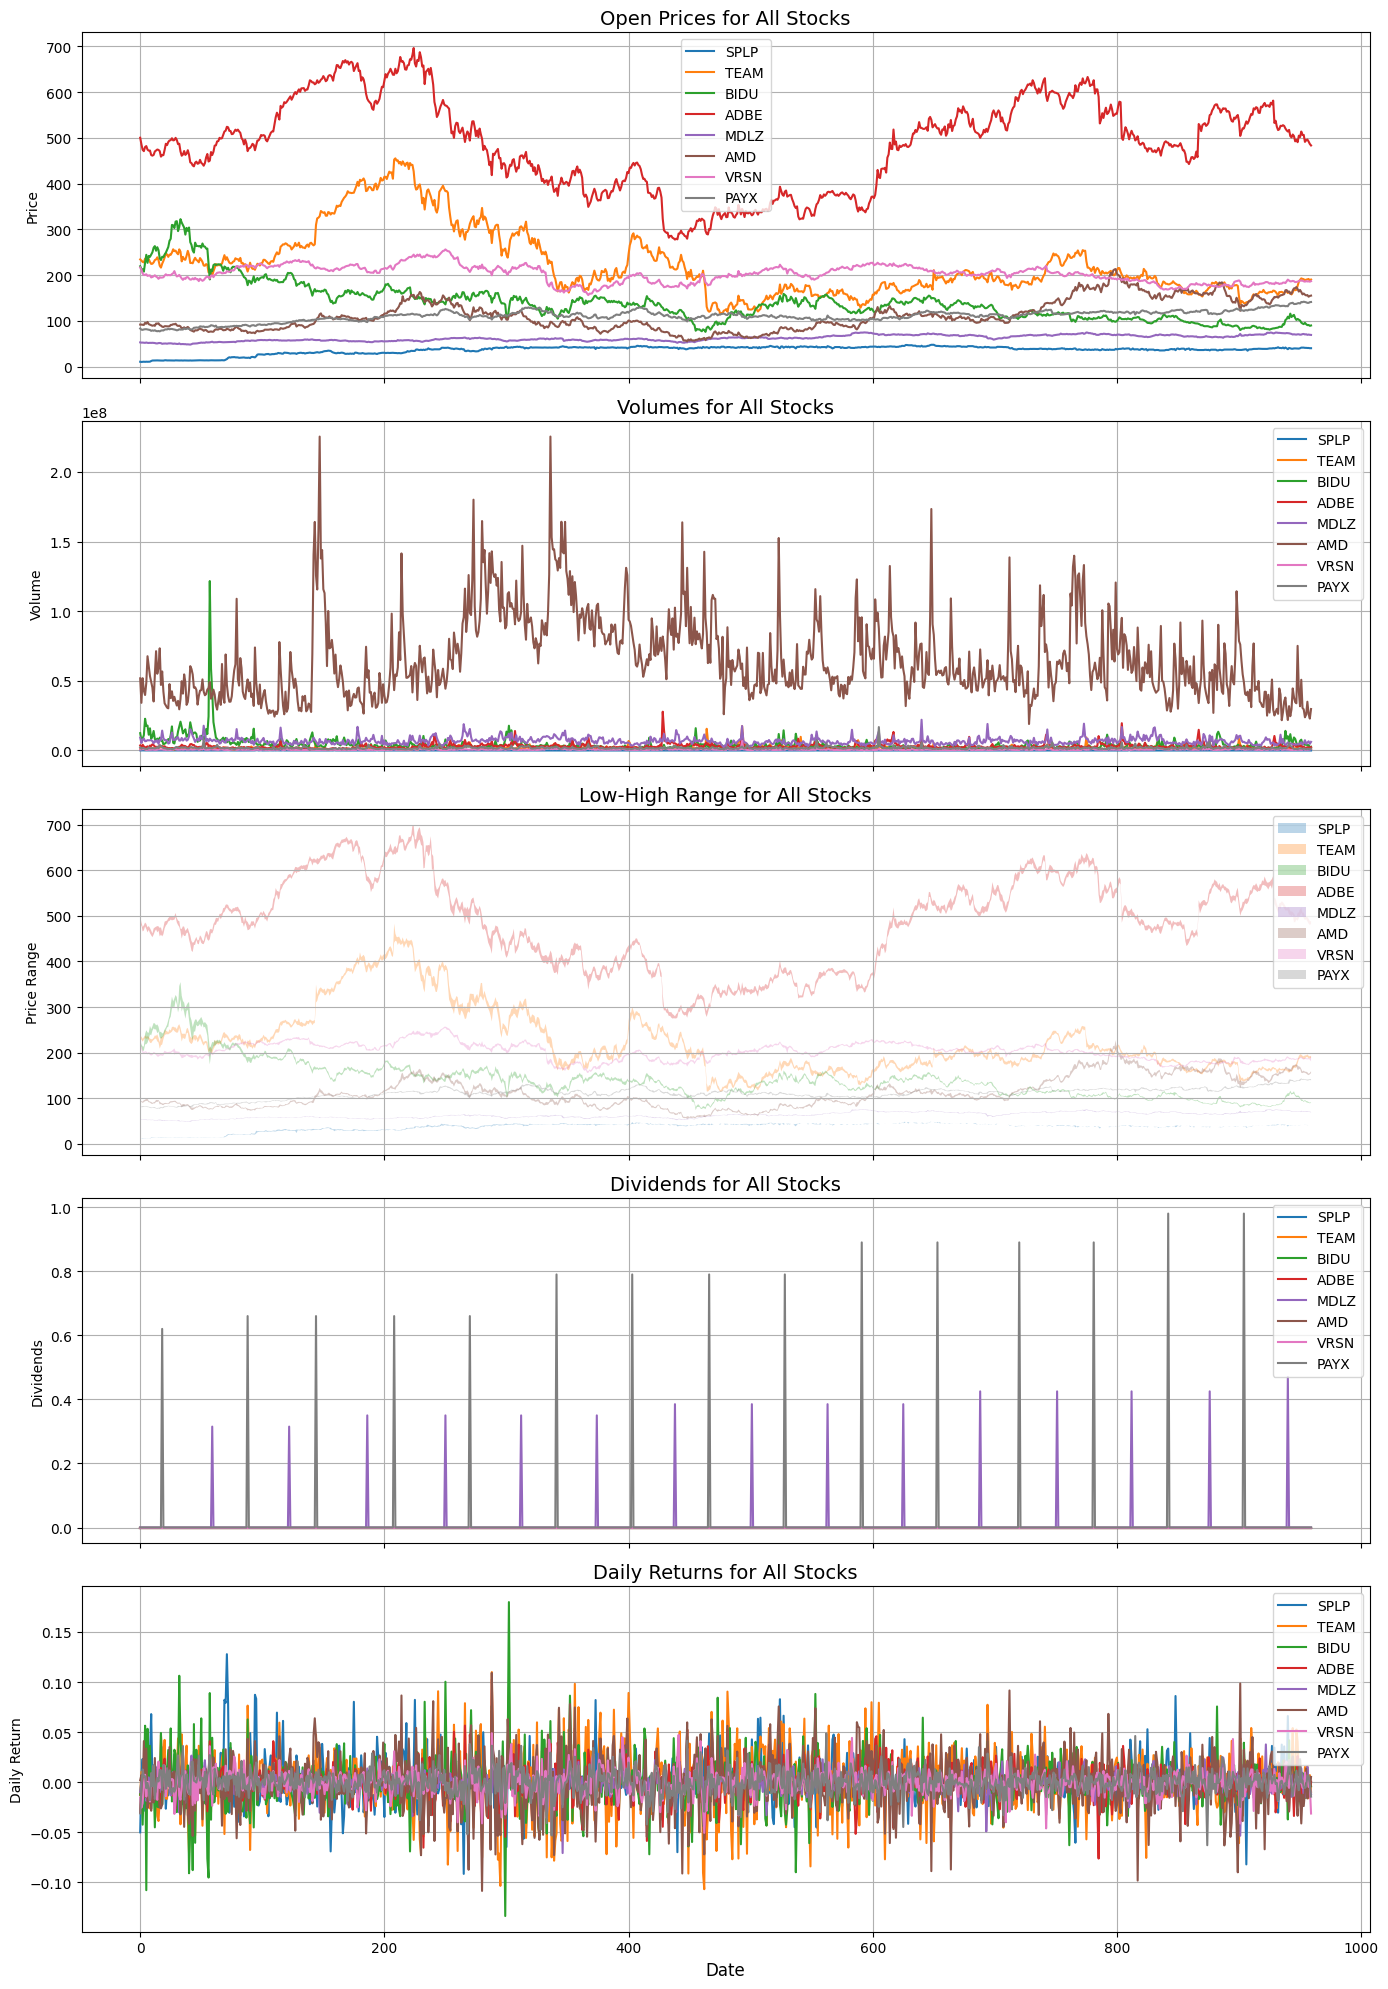

In [22]:
plot_stock_data_comparisons(all_data)

# Efficient Portfolios

In [79]:
stock_returns.index = pd.to_datetime(stock_returns.index)
risk_free_rate.index = pd.to_datetime(risk_free_rate.index)
start_date = '2021-01-01'
end_date = '2022-10-24'

# Filter the data by date range using the index
stock_returns_subset = stock_returns[(stock_returns.index >= start_date) & 
                                  (stock_returns.index <= end_date)]
risk_free_rate_subset = risk_free_rate[(risk_free_rate.index >= start_date) & 
                                  (risk_free_rate.index <= end_date)]

In [93]:
expected_returns = stock_returns_subset.mean()
covariance_matrix = stock_returns_subset.cov()
daily_risk_free_rate = risk_free_rate_subset['Daily_Rate'].mean()
print(expected_returns, "\n", covariance_matrix, "\n Mean daily risk free rate: ", f"{daily_risk_free_rate:.4}")

SPLP    0.001593
TEAM    0.000064
BIDU   -0.000756
ADBE   -0.000537
MDLZ   -0.000238
AMD    -0.001152
VRSN   -0.000038
PAYX    0.000426
dtype: float64 
           SPLP      TEAM      BIDU      ADBE      MDLZ       AMD      VRSN  \
SPLP  0.000555  0.000070  0.000074  0.000069  0.000003  0.000089  0.000039   
TEAM  0.000070  0.001006  0.000437  0.000401  0.000050  0.000526  0.000226   
BIDU  0.000074  0.000437  0.000864  0.000238  0.000043  0.000337  0.000119   
ADBE  0.000069  0.000401  0.000238  0.000348  0.000052  0.000327  0.000173   
MDLZ  0.000003  0.000050  0.000043  0.000052  0.000111  0.000041  0.000059   
AMD   0.000089  0.000526  0.000337  0.000327  0.000041  0.000822  0.000192   
VRSN  0.000039  0.000226  0.000119  0.000173  0.000059  0.000192  0.000202   
PAYX  0.000052  0.000167  0.000103  0.000134  0.000067  0.000154  0.000112   

          PAYX  
SPLP  0.000052  
TEAM  0.000167  
BIDU  0.000103  
ADBE  0.000134  
MDLZ  0.000067  
AMD   0.000154  
VRSN  0.000112  
PAYX  0.

In [94]:
def portfolio_values(weights, expected_returns, covariance, days):
    portfolio_return = np.sum(weights * expected_returns) * days 
    std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(days)
    return portfolio_return, std_dev

In [95]:
# Set constants
year = 252  # Days in a trading year
assets = len(expected_returns) #number of assets (excluding risk free)

In [96]:
def min_volatility_weights(target_return, expected_returns, covariance_matrix, num_assets, short):
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # sum(weights) = 1
        {"type": "eq", "fun": lambda w: np.sum(w * expected_returns) * year - target_return}  # return = target return
    )
    #(0,1) w/o short, (-1,1) w/ short
    if short:
        bounds = tuple((-1, 1) for _ in range(num_assets))
    else:
        bounds = tuple((0, 1) for _ in range(num_assets)) 
    
    weights = minimize(
        fun=lambda w: portfolio_values(w, expected_returns, covariance_matrix, year)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not weights.success:
        raise ValueError("Error: " + result.message)
    
    return weights.x

In [234]:
# Generate efficient frontier points without short selling
target_returns = np.linspace(expected_returns.min()*year, expected_returns.max()*year, 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = min_volatility_weights(target_return, expected_returns, covariance_matrix, num_assets, False)
    ret, risk = portfolio_values(weights, expected_returns, covariance_matrix, year)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - daily_risk_free_rate*year) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]
tangency_weights = min_volatility_weights(tangency_return, expected_returns, covariance_matrix, num_assets, False)

# Slope of the Capital Market Line (CML)
slope_cml = (tangency_return - daily_risk_free_rate*year) / tangency_risk

# Calculate x_cml and y_cml (Capital Market Line)
x_cml = np.linspace(0, max(frontier_risks), 100)
y_cml = daily_risk_free_rate*year + slope_cml * x_cml
print(tangency_weights)

[6.35249957e-01 0.00000000e+00 0.00000000e+00 4.94396191e-17
 2.77555756e-17 3.72965547e-17 0.00000000e+00 3.64750043e-01]


In [186]:
# Generate efficient frontier points with short selling
target_returns_s = np.linspace(expected_returns.min()*year, expected_returns.max()*year*2.5, 100)
frontier_returns_s = []
frontier_risks_s = []

for target_return in target_returns_s:
    weights = min_volatility_weights(target_return, expected_returns, covariance_matrix, num_assets, True)
    ret, risk = portfolio_values(weights, expected_returns, covariance_matrix, year)
    frontier_returns_s.append(ret)
    frontier_risks_s.append(risk)

# Calculate Capital Market Line
max_sharpe_index_s = np.argmax([ (ret - daily_risk_free_rate*year) / risk for ret, risk in zip(frontier_returns_s, frontier_risks_s)])

tangency_return_s = frontier_returns_s[max_sharpe_index_s]
tangency_risk_s = frontier_risks_s[max_sharpe_index_s]
tangency_weights_s = min_volatility_weights(tangency_return_s, expected_returns, covariance_matrix, num_assets, True)

# Slope of the Capital Market Line (CML)
slope_cml_s = (tangency_return_s - daily_risk_free_rate*year) / tangency_risk_s

# Calculate x_cml and y_cml (Capital Market Line)
x_cml_s = np.linspace(0, max(frontier_risks_s), 100)
y_cml_s = daily_risk_free_rate*year + slope_cml_s * x_cml_s
print(tangency_weights_s)

[ 0.98034874  0.50667145 -0.19270241 -0.9376265  -0.36867839 -0.58881491
  0.60080201  1.        ]


C:\Users\vojta\AppData\Local\Temp\ipykernel_10476\400888379.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(risks[i]+0.005, returns[i],


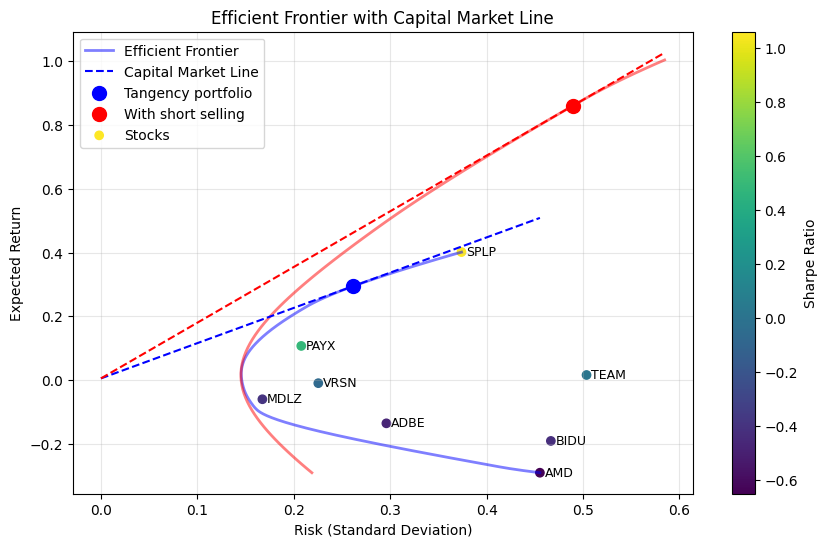

In [235]:
# Create a plot
plt.figure(figsize=(10, 6))


# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        alpha = 0.5, 
        label='Efficient Frontier')
plt.plot(frontier_risks_s, frontier_returns_s, 
        color='red', 
        linewidth=2, 
        alpha = 0.5)

# Plot CML
plt.plot(x_cml, y_cml, 
color='blue', 
        linestyle='--', 
        label='Capital Market Line')
plt.plot(x_cml_s, y_cml_s, 
color='red', 
        linestyle='--')

# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
          color='blue', 
          marker='o', 
          s=100, 
          label='Tangency portfolio')
plt.scatter(tangency_risk_s, tangency_return_s, 
          color='red', 
          marker='o', 
          s=100, 
          label='With short selling')

# Plot individual assets (stocks)
tickers = list(stock_files.keys())
# Calculate risks and returns for all stocks
risks = np.sqrt(np.diag(covariance_matrix)) * np.sqrt(year)  # Standard deviation
returns = expected_returns * year  # Annualized returns
sratios = (returns - risk_free_rate_one*year) / risks #Sharpe ratios

# Plot all stocks in one scatter call
scatter = plt.scatter(risks, returns, 
                      c=sratios, 
                      alpha=1, 
                      label='Stocks')

# Add tickers as text annotations
for i, ticker in enumerate(tickers):
    plt.text(risks[i]+0.005, returns[i], 
             ticker, 
             fontsize=9, 
             ha='left', 
             va='center')

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



[1.3634655247074976, 0.3805553017132267, 0.3060866685870644, 0.33438648850626074, 0.09498619390009587, 0.4077957887241478, 0.23431671262224343, 0.3430477447668461] [-0.001036256961185783, -0.10015813940227988, -0.2851623301284164, -0.238226789826745, -0.09302739266977392, -0.41447668101838736, -0.08320721676804446, 0.0018730011551997341]


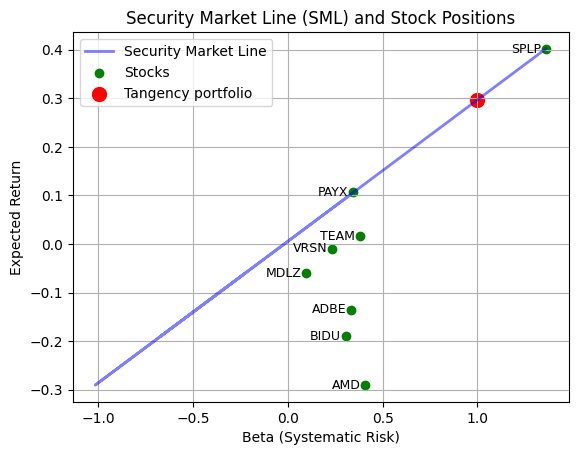

In [229]:
# Assume 'market_return' is the market's return (you can use a relevant benchmark like the S&P 500)
# beta = covariance_matrix.iloc[:, 0] / covariance_matrix.iloc[0, 0]  # Simplified calculation using first stock as market proxy
# expected_market_return = 0.0006  # Assumed daily expected market return (about 15% annually) ???
# sml = daily_risk_free_rate * year + beta * (expected_market_return - daily_risk_free_rate * year)  # SML formula


beta_sml = (expected_returns - daily_risk_free_rate )* year / (tangency_return - daily_risk_free_rate * year)
# beta_s = (expected_returns - daily_risk_free_rate * year) / (tangency_return_s - daily_risk_free_rate * year)

# Compute the SML
betas_sml = np.linspace(0, 2, 100)  # Beta range for the SML
sml_returns = daily_risk_free_rate * year + betas_sml * (tangency_return - daily_risk_free_rate * year)

daily_tangency_returns = stock_returns_subset.values @ tangency_weights
y = (stock_returns_subset.subtract(risk_free_rate_subset['Daily_Rate'],axis=0))*year
x = (daily_tangency_returns - risk_free_rate_subset['Daily_Rate'])*year
x = sm.add_constant(x)

alphas = []
betas = []
for ticker in tickers:
    model = sm.OLS(y[ticker].values,x).fit()
    alpha, beta = model.params
    alphas.append(alpha)
    betas.append(beta)



#result = sm.OLS(y[:,0], x).fit()
returns = np.array(alphas) + daily_risk_free_rate * year + np.array(betas) * (tangency_return - daily_risk_free_rate*year)
print(betas, alphas)


# plt.figure(figsize=(10, 6))
# plt.plot(betas_sml, sml_returns, color='blue', label='Security Market Line (SML)')
# plt.axhline(risk_free_rate, color='gray', linestyle='--', label='Risk-Free Rate')

# # Plot individual stocks
# #plt.scatter(np.array(betas), returns)
#     #plt.text(row['Beta'], row['Expected_Return'], f" {row['Stock']}", fontsize=9)

# # Add labels and legend
# plt.title('Security Market Line and Stocks')
# plt.xlabel('Beta')
# plt.ylabel('Expected Return')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot the SML
plt.plot(beta_sml, expected_returns*year, label="Security Market Line", color='blue', linewidth=2, alpha=0.5)
plt.scatter(np.array(betas), returns, label='Stocks', color='green')
for i, ticker in enumerate(tickers):
    plt.text(np.array(betas)[i]-0.025, returns[i], 
             ticker, 
             fontsize=9, 
             ha='right', 
             va='center')

plt.scatter(1, tangency_return, 
          color='red', 
          marker='o', 
          s=100, 
          label='Tangency portfolio')
# # Plot individual stocks based on their expected returns and betas
# plt.scatter(beta, expected_returns, color='red', label="Stocks")
# for i, ticker in enumerate(tickers):
#     plt.annotate(ticker, (beta[i], expected_returns[i]))

# # Labels and title
plt.title("Security Market Line (SML) and Stock Positions")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [205]:
print(np.append(expected_returns.values,1))

[ 1.59322165e-03  6.40218880e-05 -7.56178277e-04 -5.37222634e-04
 -2.37687455e-04 -1.15179459e-03 -3.77070351e-05  4.25563332e-04
  1.00000000e+00]


[0.5498703474982728, 0.09809651067757816, -0.14295988648086116, -0.0790572038224467, 0.009501878210858624, -0.26065363158648586, 0.06837957255266072, 0.11850156025239034] [-0.07383300265274995, -0.07315739496487457, -0.07386877180365194, -0.07329583059198294, -0.07348536872270142, -0.07299654720409993, -0.073400407040205, 0.0005152410707069469]


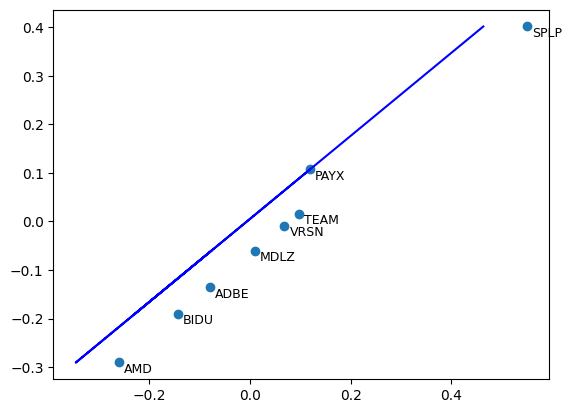

In [223]:
beta_sml_s = (expected_returns - daily_risk_free_rate) * year / (tangency_return_s - daily_risk_free_rate * year)

daily_tangency_returns_s = stock_returns_subset.values @ tangency_weights_s
y = (stock_returns_subset.subtract(risk_free_rate_subset['Daily_Rate'],axis=0))*year
x = (daily_tangency_returns_s - risk_free_rate_subset['Daily_Rate'])*year
x = sm.add_constant(x)

alphas = []
betas = []
for ticker in tickers:
    model = sm.OLS(y[ticker].values,x).fit()
    alpha, beta = model.params
    alphas.append(alpha)
    betas.append(beta)



#result = sm.OLS(y[:,0], x).fit()
returns = np.array(alphas) + daily_risk_free_rate * year + np.array(betas) * (tangency_return_s - daily_risk_free_rate*year)
print(betas, alphas)


# plt.figure(figsize=(10, 6))
# plt.plot(betas_sml, sml_returns, color='blue', label='Security Market Line (SML)')
# plt.axhline(risk_free_rate, color='gray', linestyle='--', label='Risk-Free Rate')

# # Plot individual stocks
# #plt.scatter(np.array(betas), returns)
#     #plt.text(row['Beta'], row['Expected_Return'], f" {row['Stock']}", fontsize=9)

# # Add labels and legend
# plt.title('Security Market Line and Stocks')
# plt.xlabel('Beta')
# plt.ylabel('Expected Return')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot the SML
plt.plot(beta_sml_s, expected_returns*year, label="Security Market Line (SML)", color='blue')
plt.scatter(np.array(betas), returns)
for i, ticker in enumerate(tickers):
    plt.text(np.array(betas)[i]+0.01, returns[i], 
             ticker, 
             fontsize=9, 
             ha='left', 
             va='top')


# # Plot individual stocks based on their expected returns and betas
# plt.scatter(beta, expected_returns, color='red', label="Stocks")
# for i, ticker in enumerate(tickers):
#     plt.annotate(ticker, (beta[i], expected_returns[i]))

# # Labels and title
# plt.title("Security Market Line (SML) and Stock Positions")
# plt.xlabel("Beta (Systematic Risk)")
# plt.ylabel("Expected Return")
# plt.legend(loc="upper left")
# plt.grid(True)
# plt.show()

# The Markowitz Model

We have choosen strategy of min risk, min expected returns = 6 % p.a, the historical/empirical data was used.

#TODO: Try different estimation methods

In [ ]:
def calculate_efficient_portfolio_with_rf(combined_returns, min_return, risk_free_rate):
    # Calculate excess returns and covariance matrix
    excess_returns = combined_returns.mean() - risk_free_rate
    covariance_matrix = combined_returns.cov()
    num_risky_assets = len(excess_returns)
    
    def objective(w):
        risky_weights = w[:-1]
        return 0.5 * np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights))
    
    def return_constraint(w):
        risky_weights = w[:-1]
        rf_weight = w[-1]
        portfolio_excess_return = np.dot(risky_weights, excess_returns)
        return portfolio_excess_return + risk_free_rate - min_return
    
    def weight_sum_constraint(w):
        return np.sum(w) - 1
    
    constraints = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'ineq', 'fun': return_constraint}
    ]
    
    initial_weights = np.ones(num_risky_assets + 1) / (num_risky_assets + 1)
    bounds = [(0, 1) for _ in range(num_risky_assets + 1)]
    
    result = minimize(objective, initial_weights,
                     constraints=constraints,
                     bounds=bounds,
                     method='SLSQP')
    
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")
    
    weights = result.x
    risky_weights = weights[:-1]
    rf_weight = weights[-1]
    
    portfolio_risk = np.sqrt(np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights)))
    portfolio_return = np.dot(risky_weights, combined_returns.mean()) + rf_weight * risk_free_rate
    
    weight_dict = dict(zip(combined_returns.columns, risky_weights))
    weight_dict['risk_free'] = rf_weight
    
    return {
        'weights': weight_dict,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rf_weight
    }

In [218]:
def calculate_efficient_portfolio_with_rf(min_return, expected_returns, covariance_matrix, num_risky_assets, risk_free_rate):
    # Calculate excess returns and covariance matrix
    excess_returns = expected_returns - risk_free_rate
    
    def objective(w):
        return 0.5 * np.dot(w.T, np.dot(covariance_matrix, w))*year
    
    def return_constraint(w):
        portfolio_excess_return = np.dot(w, excess_returns)
        return portfolio_excess_return + risk_free_rate - min_return
    
    constraints = [
        {'type': 'ineq', 'fun': return_constraint}
    ]
    
    initial_weights = np.zeros(num_risky_assets) / (num_risky_assets)
    bounds = [(-1, 1) for _ in range(num_risky_assets)]
    
    result = minimize(
        fun=lambda w: objective(w),
        x0=num_risky_assets * [1.0 / (num_risky_assets+1)],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")
    
    weights = result.x
    risky_weights = weights
    rf_weight = 1-np.sum(risky_weights)
    
    portfolio_risk = np.sqrt(np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights)))
    portfolio_return = (np.dot(risky_weights, expected_returns) + rf_weight * risk_free_rate)
    
    # weight_dict = dict(zip(expected_returns.columns, risky_weights))
    # weight_dict['risk_free'] = rf_weight
    
    return {
        'weights': risky_weights,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rf_weight
    }

In [219]:
expected_returns = combined_returns_cleaned.mean()
covariance_matrix = combined_returns_cleaned.cov()
risk_free_rate_all = risk_free_rate_cleaned['Daily_Risk_Free_Rate'].mean()

In [220]:
# Example usage:
# Replace `stock_data` with your data (a dictionary of DataFrames with 'Close' prices for each stock)
# Set a minimum daily return (e.g., 0.00023 for ~6% annual return)
min_return = 0.00023
portfolioMark = calculate_efficient_portfolio_with_rf(min_return, expected_returns, covariance_matrix, num_assets, risk_free_rate_all)

print("Portfolio weights:", portfolioMark['weights'])
print("Expected return:", portfolioMark['portfolio_return'])
print("Portfolio risk:", portfolioMark['portfolio_risk'])
print("Risk-free asset weight:", portfolioMark['risk_free_weight'])
print(sum(portfolioMark['weights'])+portfolioMark['risk_free_weight'])

Portfolio weights: [ 0.04364256  0.0184409  -0.00435527 -0.02028767  0.00068646 -0.00591173
 -0.01364523 -0.0012276 ]
Expected return: 0.00023000000000883512
Portfolio risk: 0.0009790397763387597
Risk-free asset weight: 0.9826575795552773
1.0


C:\Users\vojta\AppData\Local\Temp\ipykernel_17748\2068781636.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i]*timeAnnual,


AttributeError: 'numpy.ndarray' object has no attribute 'items'

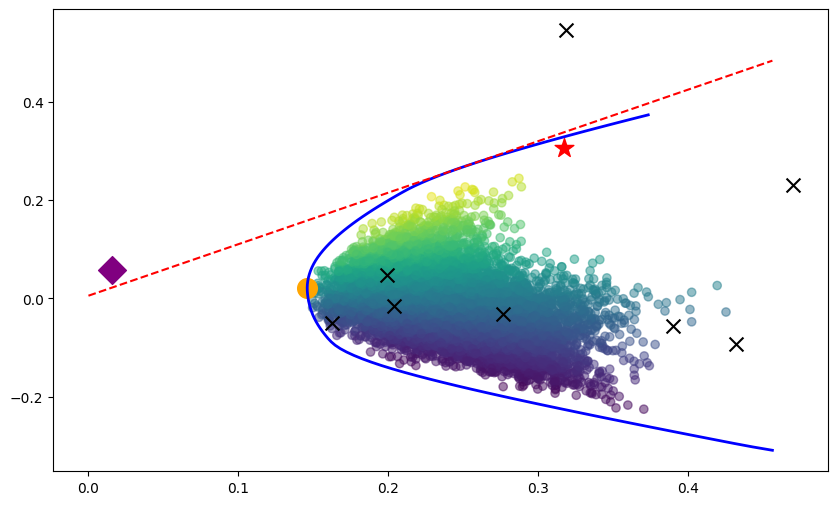

In [221]:
# Your existing plot code with Markowitz additions
plt.figure(figsize=(10, 6))

# Plot random portfolios (your existing code)
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot efficient frontier (your existing code)
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        label='Efficient Frontier')

# Get Markowitz results and add to plot
markowitz_risk = portfolioMark['portfolio_risk'] * np.sqrt(year)
markowitz_return = portfolioMark['portfolio_return'] * year

# Plot Markowitz optimal portfolio
plt.scatter(markowitz_risk, markowitz_return,
           color='purple',
           marker='D',
           s=200,
           label='Markowitz Optimal')

# Plot CML using Markowitz portfolio (your existing code, updated)
plt.plot(x_cml, y_cml, 
         color='red', 
         linestyle='--', 
         label='Capital Market Line (CML)')

# Your existing code continues...
# Plot maximum Sharpe ratio point
plt.scatter(max_sharpe_stddev, max_sharpe_return, 
          color='red', 
          marker='*', 
          s=200, 
          label='Maximum Sharpe ratio')

# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
          color='orange', 
          marker='o', 
          s=200, 
          label='Minimum Variance')

# Plot individual assets (stocks)
for i in range(len(expected_returns)):
    plt.scatter(np.sqrt(covariance_matrix.iloc[i, i])* np.sqrt(year),
                expected_returns[i]*year,
                color='black', 
                marker='x', 
                s=100, 
                label=f'Stock' if i == 0 else "")

# Add Markowitz weights as text
weights_text = "Markowitz Weights:\n"
for asset, weight in portfolioMark['weights'].items():
    weights_text += f"{asset}: {weight:.3f}\n"
plt.text(0.02, 0.02, weights_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=8)

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [66]:
def calculate_minimum_risk_portfolio(combined_returns, min_return, risk_free_rate):
    """
    Minimize portfolio risk subject to a minimum expected return, considering the risk-free rate.
    
    Parameters:
    combined_returns (pd.DataFrame): DataFrame with asset returns (stocks as columns).
    min_return (float): Minimum expected return (daily).
    risk_free_rate (float): The risk-free rate (daily), assumed constant over time.

    Returns:
    dict: Portfolio weights and resulting risk/return.
    """
    # Init characteristics
    expected_returns = combined_returns.mean() - risk_free_rate  # Adjust expected returns for the risk-free rate
    covariance_matrix = combined_returns.cov()
    num_assets = len(expected_returns)
    
    # Initial guess for weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Constraints: Weights sum to 1, portfolio return >= min_return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: np.dot(w, expected_returns) - min_return}  # Portfolio return >= min_return
    ]
    
    # Bounds for weights (0 to 1)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Objective function: Portfolio risk (standard deviation)
    def portfolio_risk(w):
        return np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))
    
    # Minimize portfolio risk
    resultMark = minimize(portfolio_risk, initial_weights, constraints=constraints, bounds=bounds)
    
    # Check if optimization was successful
    if not resultMark.success:
        raise ValueError("Optimization failed:", resultMark.message)
    
    # Portfolio weights, risk, and return
    weights = resultMark.x
    portfolio_return = np.dot(weights, expected_returns) + risk_free_rate  # Adjust portfolio return back to actual return
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return {
        'weights': dict(zip(combined_returns.columns, weights)),
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk
    }


In [67]:
# Example usage:
# Replace `stock_data` with your data (a dictionary of DataFrames with 'Close' prices for each stock)
# Set a minimum daily return (e.g., 0.00023 for ~6% annual return)
min_return = 0.00023
resultMark = calculate_minimum_risk_portfolio(combined_returns_subset, min_return, risk_free_rate_one)

In [68]:
# Print optimal portfolio weights and performance
print("Optimal Portfolio Weights:", resultMark['weights'])
print(f"Portfolio Expected Return: {resultMark['portfolio_return']}")
print(f"Portfolio Risk (Std Dev): {resultMark['portfolio_risk']}")
print(sum(resultMark['weights'].values()))

Optimal Portfolio Weights: {'SPLP': 0.17814225983654894, 'TEAM': 0.0, 'BIDU': 0.0, 'ADBE': 4.7704895589362195e-18, 'MDLZ': 0.5004945974110149, 'AMD': 8.673617379884035e-19, 'VRSN': 0.10179116664105513, 'PAYX': 0.21957197611138118}
Portfolio Expected Return: 0.00025157817477815714
Portfolio Risk (Std Dev): 0.009396627381653255
1.0000000000000002


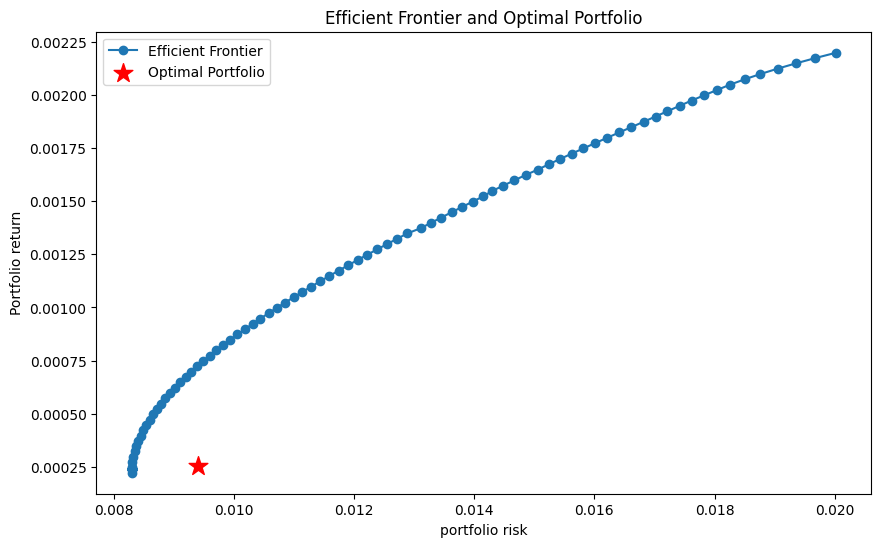

In [69]:
# Visualization: Efficient Frontier
market_return = resultMark['portfolio_return']
market_risk = resultMark['portfolio_risk']
num_portfolios = 100
results = np.zeros((3, num_portfolios))
# Get max and min expected returns to ensure feasible minimum return
min_expected_return = combined_returns.mean().min()
max_expected_return = combined_returns.mean().max()
for i in range(num_portfolios):
    # Vary the expected return for each portfolio
    min_return = min_expected_return + (i / num_portfolios) * (max_expected_return - min_expected_return)
    
    try:
        portfolio = calculate_minimum_risk_portfolio(combined_returns, min_return, risk_free_rate_one)
        results[0, i] = portfolio['portfolio_risk']
        results[1, i] = portfolio['portfolio_return']
    except ValueError as e:
        # Handle cases where optimization fails
        print(f"Optimization failed for target return {min_return:.4f}. Skipping.")
        results[0, i] = np.nan
        results[1, i] = np.nan


# Plot CML (opacko from above, still not working)
# ??? How to choose market risk and market returns
cml_x = np.linspace(0, market_risk * 1.5, 100)
cml_y = risk_free_rate_one + (cml_x / market_risk) * (market_return - risk_free_rate_one)
# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(results[0, :], results[1, :], marker='o', label='Efficient Frontier')
#plt.plot(cml_x, cml_y, color='green', label='Capital Market Line (CML)') (same naprd results)
plt.scatter(resultMark['portfolio_risk'], resultMark['portfolio_return'], color='red', marker='*', s=200, label='Optimal Portfolio')
plt.title('Efficient Frontier and Optimal Portfolio')
plt.xlabel('portfolio risk')
plt.ylabel('Portfolio return')
plt.legend(loc='best')
plt.show()

# Out-Of-Sample Investing

In [70]:
# Function to calculate the fixed tangency portfolio (Sharpe-maximizing portfolio)
def calculate_tangency_portfolio(returns, risk_free_rate_cleaned):
    # Get expected returns and covariance matrix
    expected_returns = returns.mean()
    covariance_matrix = returns.cov()
    
    # Risk-free rate (example, you can adjust based on your context)
    risk_free_rate = risk_free_rate_cleaned.mean()
    
    # Calculate excess returns (subtract risk-free rate)
    excess_returns = expected_returns - risk_free_rate
    
    # Ensure the excess returns vector has the same shape as the covariance matrix
    excess_returns = excess_returns[:covariance_matrix.shape[0]]  # Trim excess returns to match the covariance matrix shape
    
    # Calculate weights using the inverse of the covariance matrix
    weights = np.linalg.inv(covariance_matrix).dot(excess_returns)
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return {'weights': weights, 'portfolio_return': portfolio_return, 'portfolio_risk': portfolio_risk}
    
    return {'weights': weights, 'portfolio_return': portfolio_return, 'portfolio_risk': portfolio_risk}

# Example of daily investment strategy
def simulate_strategy(stock_data, min_return, start_date, end_date, risk_free_rate_cleaned):
    # Filter data for the given date range
    stock_data = stock_data.loc[start_date:end_date]
    
    # Store results
    portfolio_values_optimal = []
    portfolio_values_naive = []
    portfolio_values_tangency = []
    
    # Initialize the portfolio value (starting with $1)
    initial_value = 1
    portfolio_value_optimal = initial_value
    portfolio_value_naive = initial_value
    portfolio_value_tangency = initial_value
    
    # Simulate the investment over time
    for i in range(1, len(stock_data)):
        # Calculate returns up to the current date
        daily_returns = stock_data.iloc[:i]
        
        # Calculate optimal portfolio based on historical data
        optimal_portfolio = calculate_minimum_risk_portfolio(daily_returns, min_return)
        optimal_weights = optimal_portfolio['weights']
        
        # Naive portfolio (equal weights)
        num_assets = len(daily_returns.columns)
        naive_weights = np.ones(num_assets) / num_assets
        
        # Fixed tangency portfolio (based on entire data)
        tangency_portfolio = calculate_tangency_portfolio(daily_returns,risk_free_rate_cleaned)
        tangency_weights = tangency_portfolio['weights']
        
        # Calculate daily returns for each strategy
        daily_returns_optimal = np.dot(daily_returns.iloc[i], optimal_weights)
        daily_returns_naive = np.dot(daily_returns.iloc[i], naive_weights)
        daily_returns_tangency = np.dot(daily_returns.iloc[i], tangency_weights)
        
        # Update portfolio values
        portfolio_value_optimal *= (1 + daily_returns_optimal)
        portfolio_value_naive *= (1 + daily_returns_naive)
        portfolio_value_tangency *= (1 + daily_returns_tangency)
        
        # Store portfolio values
        portfolio_values_optimal.append(portfolio_value_optimal)
        portfolio_values_naive.append(portfolio_value_naive)
        portfolio_values_tangency.append(portfolio_value_tangency)
    
    # Convert results to a DataFrame
    results = pd.DataFrame({
        'Date': stock_data.index[1:],
        'Optimal Portfolio Value': portfolio_values_optimal,
        'Naive Portfolio Value': portfolio_values_naive,
        'Tangency Portfolio Value': portfolio_values_tangency
    })
    
    return results


In [71]:
# Simulate the strategy for a given date range
start_date = '2022-10-25'
end_date = '2024-10-24'
min_return = 0.00023  # Example minimum daily return (~6% annual return)

# Simulate the strategy and get the results
portfolio_results = simulate_strategy(combined_returns_cleaned, min_return, start_date, end_date, risk_free_rate_cleaned)

# Plot the portfolio values over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_results['Date'], portfolio_results['Optimal Portfolio Value'], label='Optimal Strategy')
plt.plot(portfolio_results['Date'], portfolio_results['Naive Portfolio Value'], label='Naive Strategy')
plt.plot(portfolio_results['Date'], portfolio_results['Tangency Portfolio Value'], label='Tangency Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Performance Comparison')
plt.legend()
plt.show()

# Print the final portfolio values and compare them
final_optimal_value = portfolio_results['Optimal Portfolio Value'].iloc[-1]
final_naive_value = portfolio_results['Naive Portfolio Value'].iloc[-1]
final_tangency_value = portfolio_results['Tangency Portfolio Value'].iloc[-1]

print(f"Final Optimal Portfolio Value: {final_optimal_value}")
print(f"Final Naive Portfolio Value: {final_naive_value}")
print(f"Final Tangency Portfolio Value: {final_tangency_value}")

TypeError: calculate_minimum_risk_portfolio() missing 1 required positional argument: 'risk_free_rate'